In [36]:
import numpy as np
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import pdspy.modeling as modeling
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D 
import os
import pickle

import george
from george import kernels
from scipy.optimize import minimize

%matplotlib inline

In [37]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)
    
dictionary=np.load("../grid_metadata/dictionary.npy")

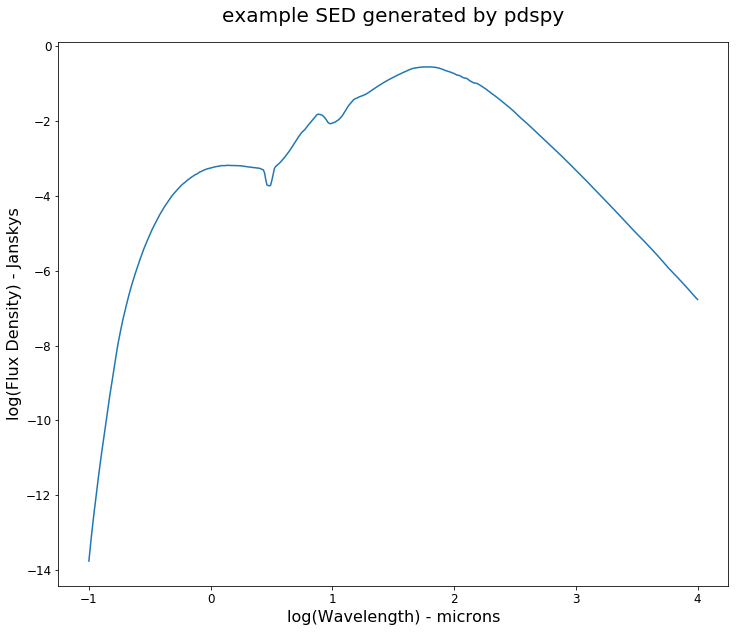

In [38]:
plt.figure(figsize=(12,10))
plt.plot(np.log10(xvals),cube[16])
plt.xlabel("log(Wavelength) - microns").set_fontsize(16)
plt.ylabel("log(Flux Density) - Janskys").set_fontsize(16)
plt.tick_params(labelsize=12)
plt.title("example SED generated by pdspy",pad=20).set_fontsize(20)
plt.show()

In [39]:
dictionary[16]

{'Tstar': 4218.751714594813,
 'logL_star': -0.8219494730537672,
 'logM_disk': -6.678976808923213,
 'logR_disk': 1.872527232441081,
 'h_0': 0.16330757481044356,
 'logR_in': -0.49760982277855625,
 'gamma': 0.6243294365074424,
 'beta': 1.083654218736818,
 'logM_env': -7.438784963711289,
 'logR_env': 2.881130921898599,
 'f_cav': 0.6154995415954266,
 'ksi': 0.7296769592070813,
 'loga_max': 4.555789974325001,
 'p': 4.279627681808531,
 'incl': 77.50844382956491,
 'filename': 'Tstar_4218.752_logLstar_-0.822_logMdisk_-6.679_logRdisk_1.873_h0_0.163_logRin_-0.498_gamma_0.624_beta_1.084_logMenv_-7.439_logRenv_2.1_fcav_0.615_ksi_0.730_logamax_4.556_p_4.280_incl_77.508.hdf5'}

In [68]:
param_names = ["T_star","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]
steps=[]
bases=[]
for i in range(len(ranges)):
    steps.append(np.linspace(ranges[i][0],ranges[i][1],11))
    bases.append(steps[i][5])

# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)[100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

In [69]:
# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

done in 0.048s


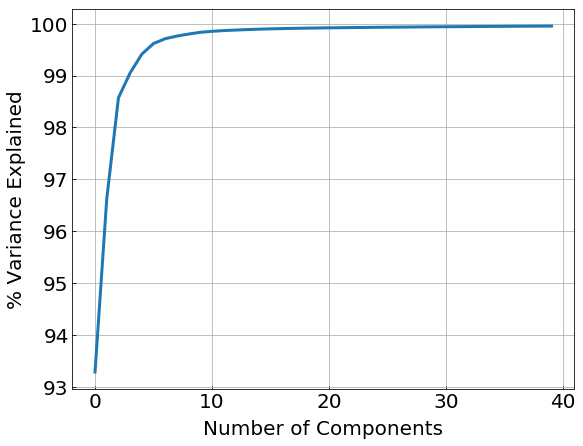

In [70]:
fig,ax=plt.subplots(1,figsize=(9,7))
plt.ylabel('% Variance Explained',fontsize=20)
plt.xlabel('Number of Components',fontsize=20,labelpad=8)
ax.plot(np.cumsum(pca.explained_variance_ratio_)*100,lw=3)
ax.tick_params(labelsize=20,direction="in")
plt.grid()
plt.show()

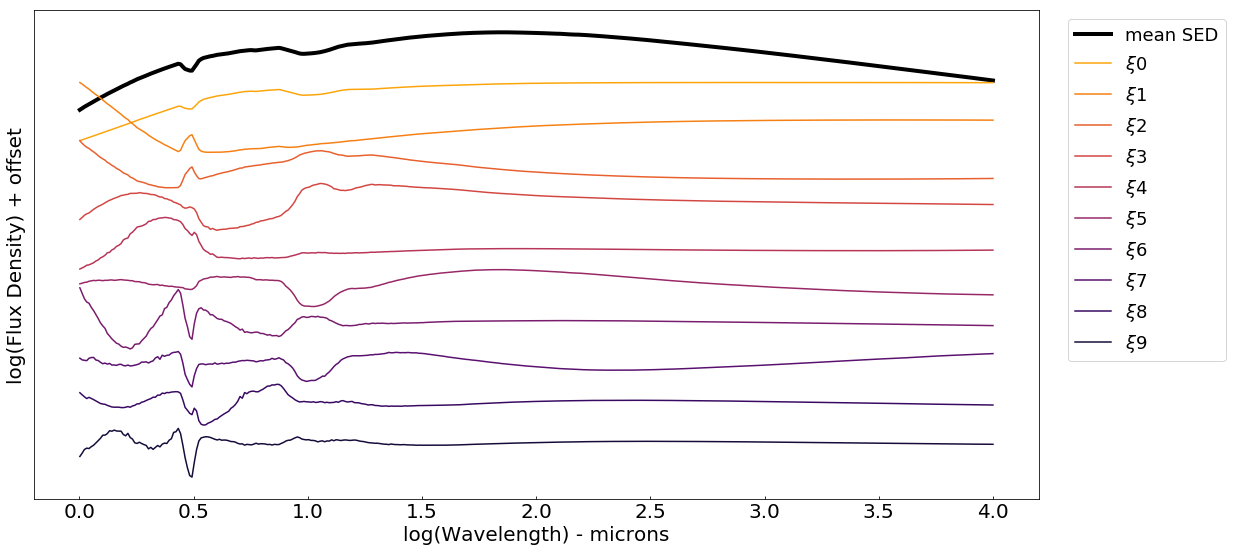

In [71]:
colors=plt.cm.inferno(np.linspace(0.1,0.8,10))
plt.figure(figsize=(18,9))
plt.plot(np.log10(xvals),np.mean(cube,axis=0),c='k',label="mean SED",lw=4)
#plt.plot(np.log10(xvals),np.std(cube,axis=0),c='k',label="standard deviation, grid SEDs",linestyle="--")
for i in range(10):
    plt.plot(np.log10(xvals),(17+(15-2.5*i))*eigenseds[i]-(4.5*(i+1)),c=colors[-i-1],label=r'$\xi$'+(str(i)))
plt.xlabel("log(Wavelength) - microns",fontsize=20)
plt.ylabel("log(Flux Density) + offset",fontsize=20,labelpad=8)
plt.tick_params(axis='x',labelsize=20,direction="in")
plt.tick_params(axis='y',left=False,labelleft=False)
plt.legend(bbox_to_anchor=(1.02, 1),prop={'size':18})
plt.show()

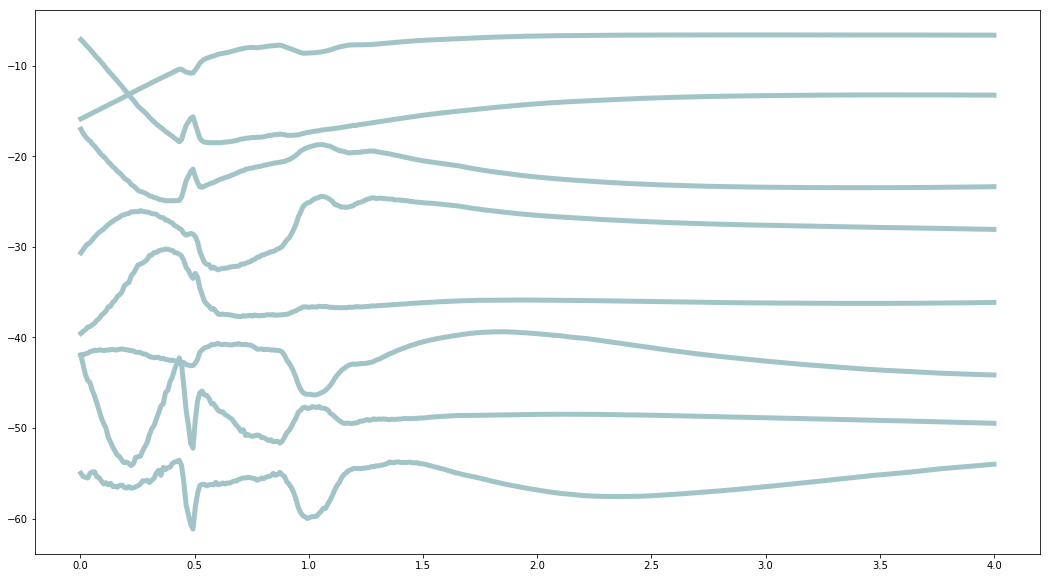

In [72]:
plt.figure(figsize=(18,10))
for i in range(8):
    plt.plot(np.log10(xvals),(25+(20-2.5*i))*eigenseds[i]-(7*(i+1)),c="#a2c4c9",lw=5)
plt.show()

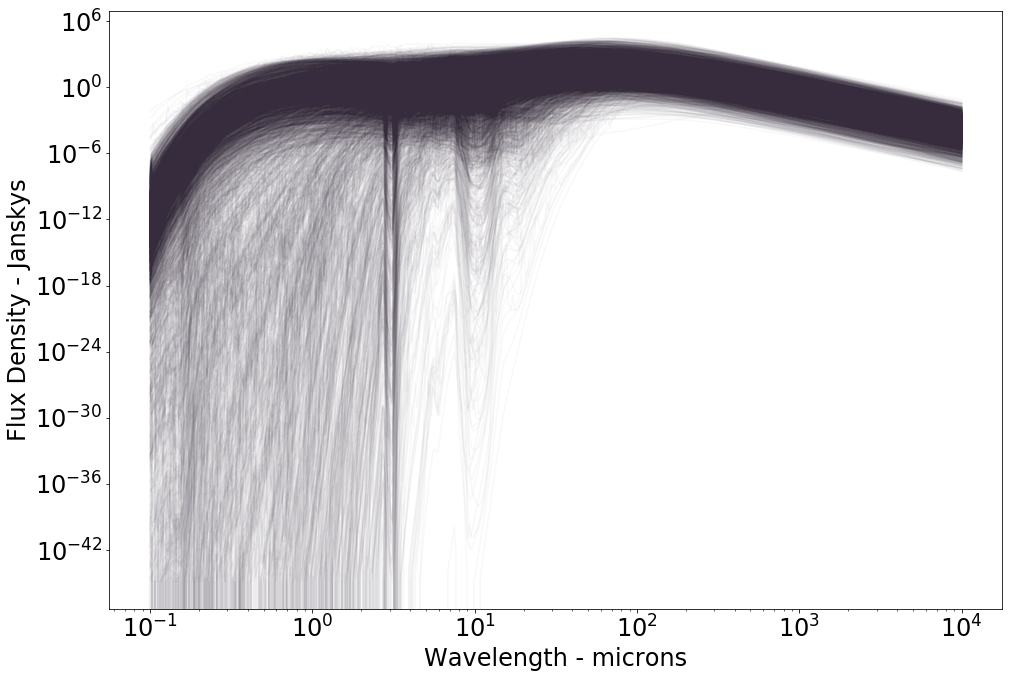

In [104]:
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)
    
plt.figure(figsize=(16,11))
for i in range(3850):
    plt.loglog(xvals,10**cube[i],c='#362c3d',alpha=0.03)
plt.xlabel("Wavelength - microns").set_fontsize(24)
plt.ylabel("Flux Density - Janskys").set_fontsize(24)
plt.tick_params(labelsize=24)
plt.show()

In [73]:
# get all model data
with open ('../grid_metadata/corefull.txt', 'rb') as fp:
    core= pickle.load(fp)
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube2 = np.array(pickle.load(fp))
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)

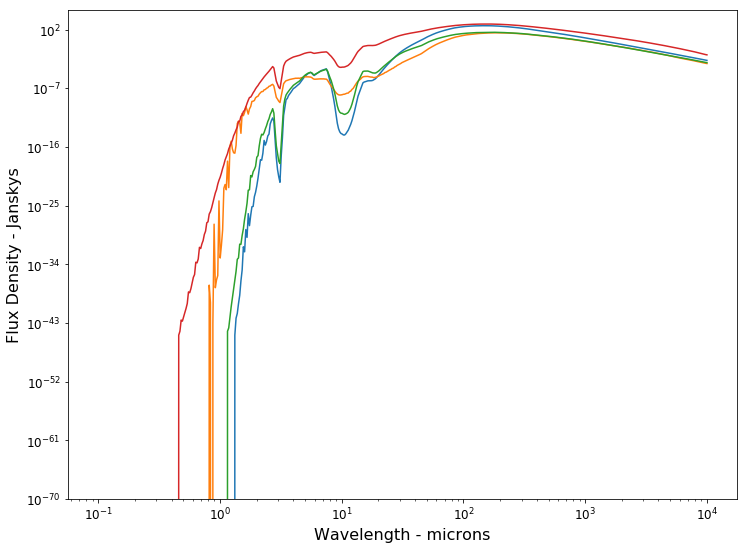

In [74]:
plt.figure(figsize=(12,9))
for i in (5,18,47,60):
    plt.loglog(xvals,10**cube2[i])
    plt.ylim(1e-70,1e5)
    plt.ylabel("Flux Density - Janskys",fontsize=16)
    plt.xlabel("Wavelength - microns",fontsize=16)
    plt.tick_params(labelsize=12)
plt.show()

In [75]:
inf=[]
for i in range(3850):
    if -np.inf in cube[i]:
        inf.append(i)

In [76]:
dictionary[1]['logM_env']

-5.632317811373863

In [77]:
pars=[]
for j in range(len(param_names)):
    pars.append([])
    for i in range(len(inf)):
        pars[j].append(dictionary[i][param_names[4]])
        

In [78]:
np.array(pars).shape

(15, 0)

In [364]:
def sedcomp_anim(model,ncomp=40,nfeat=400):
    
    fig,ax= plt.subplots(figsize=(12,9))
    ax.plot(np.log10(xvals)[0:nfeat], cube[model][0:nfeat], c='black',label="pdspy SED")
    ax.tick_params(labelsize=16)
        
    coeffs=pca.transform(seds_msub[model].reshape(1,-1)) 
    reconst=[]
    for j in range(ncomp):
        reconst.append(np.dot(coeffs[0][0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                       pca.mean_[0:nfeat]+np.nanmean(nancube[model]))
    
    line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')
    
    ann_list=[]
    def animate(i):
        if not len(ann_list)==0:
            ax.texts.remove(ax.texts[0])
        
        line.set_ydata(reconst[int(i)])
        ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
        if -np.inf in cube[model]:
            ax.set_ylim(-45,10)
        ann=ax.annotate("n = "+str(i),(1.53,-4),size=60)
        ann_list.append(ann)
        ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
        ax.set_title("reconstructed SED against pdspy SED, number of components="+str(int(i)+1),fontsize=18,pad=20)
        return line,ax
    
    fs=np.ndarray.tolist(np.arange(0,ncomp))
    for i in range(2):
        fs.append(ncomp-1)
    anim=FuncAnimation(fig,animate,frames=fs,interval=1000)
    anim.save("../talk/"+str(model)+"_reconst.gif", dpi=72, writer="imagemagick")

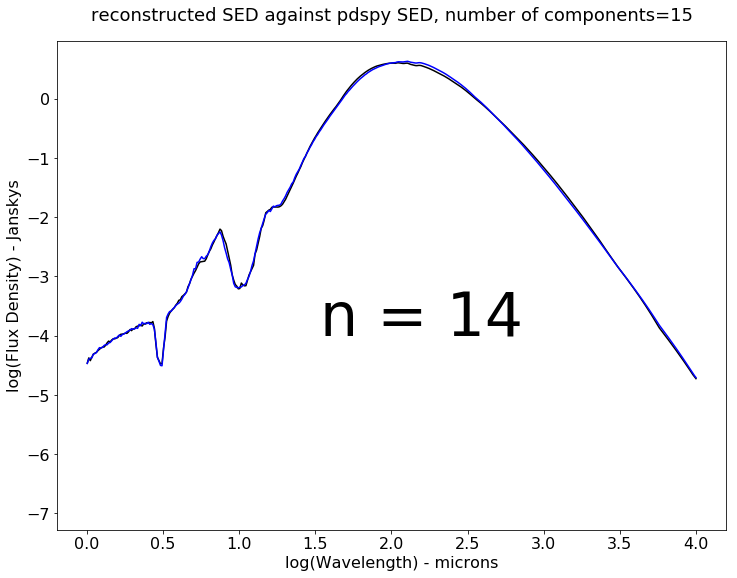

In [365]:
sedcomp_anim(35,ncomp=15)

[-6.80260101 -6.80120695 -6.80385006 -6.80523966 -6.80354006 -6.80355968
 -6.80346315 -6.80332025 -6.80305671 -6.80351868 -6.80276916 -6.80293903
 -6.80315484 -6.80298017 -6.80295184]


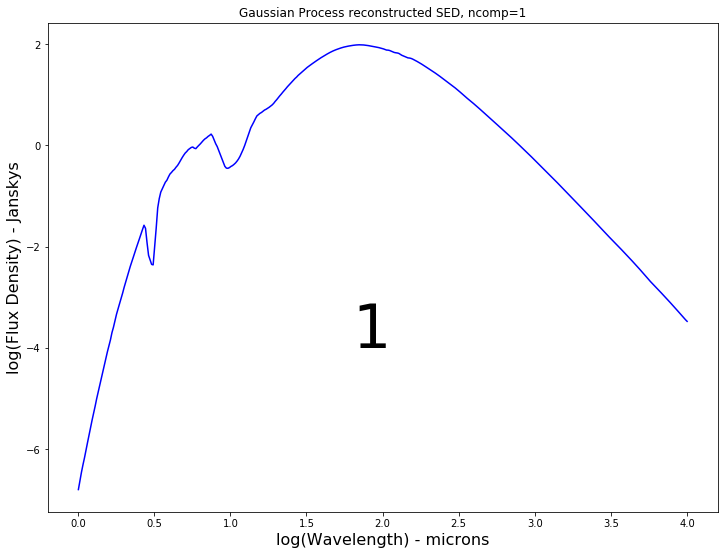

In [269]:
ncomp=15
nfeat=400
fig,ax= plt.subplots(figsize=(12,9))
coeffs=[ 0.00261589,  0.00859229, -0.02642946,  0.01958782, -0.01306668,\
        0.0094899 ,  0.00040921,  0.00391252,  0.00284936,  0.00271584,\
       -0.00346172,  0.0015432 , -0.0013069 ,  0.00112998,  0.00027086]
reconst=[]
for j in range(ncomp):
    reconst.append(np.dot(coeffs[0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                   pca.mean_[0:nfeat])

line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

ann_list=[]
def animate(i):
    if not len(ann_list)==0:
        ax.texts.remove(ax.texts[0])
    line.set_ydata(reconst[int(i)])
    ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
    ann=ax.annotate(str(i+1),(1.8,-4),size=60)
    ann_list.append(ann)
    ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
    ax.set_title("Gaussian Process reconstructed SED, ncomp="+str(int(i)+1))
    return line,ax

fs=np.ndarray.tolist(np.arange(0,ncomp))
for i in range(4):
    fs.append(ncomp-1)
anim=FuncAnimation(fig,animate,frames=fs,interval=1000)
anim.save("../talk/test_gp_reconst.gif", dpi=72, writer="imagemagick")

In [79]:
# slices - read in filenames and logspace flux values
with open ('../grid_metadata/slicenames.txt', 'rb') as fp:
    slicenames = pickle.load(fp)
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    slicevals = pickle.load(fp)[:,:,100:500]
with open ('../grid_metadata/slicevals.txt', 'rb') as fp:
    nanslicevals = pickle.load(fp)[:,:,100:500]

# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    for j in range(len(slicevals[i])):
        if -np.inf in slicevals[i][j]:
            a = slicevals[i][j].tolist()
            a.reverse()
            ind = len(a)-a.index(-np.inf)
            x1 = xvals[ind]
            y1 = slicevals[i][j][ind]
            for m in range(ind):
                slicevals[i][j][m]=(100*(np.log10(xvals[m]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=2)[:,:,np.newaxis]

In [80]:
fitdata=[]

for i in range(len(param_names)):
    fitdata.append([])
for i in range(len(param_names)):
    for j in range(11):
        modeldata=[]
        paramval=steps[i][j]
        coeffs=pca.transform(slice_seds_msub[i][j].reshape(1,-1))
        modeldata.append(paramval)
        for k in range(10):
            modeldata.append(coeffs[0][k])
        fitdata[i].append(modeldata)
paramvals=[]
weights=[]
for param in range(15):
    pl=[]
    wl=[]
    for model in range(11):
        pl.append(fitdata[param][model][0])
    paramvals.append(pl)
    
    for w in range(10):
        wsl=[]
        for model in range(11):
            wsl.append(fitdata[param][model][w+1])
        wl.append(wsl)
    weights.append(wl)
def load_pcwpar(param,weight):
    return np.array(paramvals[param]).reshape(-1,1), np.array(weights[param][weight])

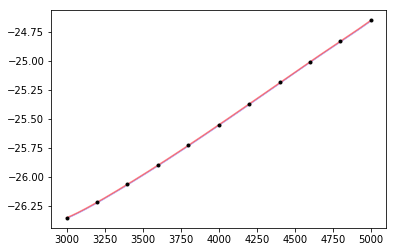

Initial ln-likelihood: -2822.51


In [81]:
X, y = load_pcwpar(0,0)

kernel = kernels.ExpSquaredKernel(900**2)* np.var(y)
gp = george.GP(kernel)
yerr=[j*0.00001 for j in y]
gp.compute(X,yerr)

x_pred = np.linspace(3000,5000,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5)
plt.errorbar(X, y,yerr,fmt=".k", capsize=0)
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

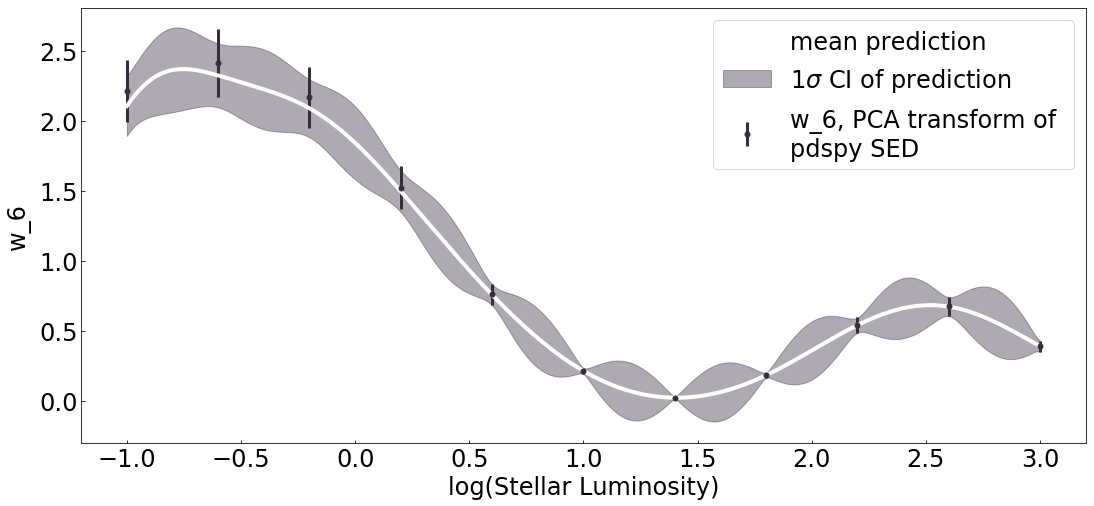

Initial ln-likelihood: -15.04


In [105]:
X, y = load_pcwpar(1,6)
yerr=[j*0.1 for j in y]

kernel = kernels.ExpSquaredKernel(.3**2) * np.var(y)

gp = george.GP(kernel)
gp.compute(X,yerr)

x_pred = np.linspace(-1,3,500)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
plt.figure(figsize=(18,8))
plt.errorbar(X, y, yerr,fmt=".",c='#362c3d',markersize=10,lw=3,label="w_6, PCA transform of \npdspy SED")
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color='#362c3d', alpha=0.4, label="1"+"$\sigma$"+" CI of prediction")
plt.plot(x_pred, pred, "white", lw=4, label="mean prediction")
plt.xlabel("log(Stellar Luminosity)",fontsize=24)
plt.ylabel("w_6",fontsize=24,labelpad=8)
plt.ylim(-0.3,2.8)
plt.tick_params(labelsize=24,direction="in")
plt.legend(prop={'size':24})
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

In [474]:

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

pred, pred_var = gp.predict(y, x_pred, return_var=True)

      fun: 0.4089847696845941
 hess_inv: array([[0.77305702, 0.2416093 ],
       [0.2416093 , 0.14045307]])
      jac: array([-0.00000013,  0.00000017])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([0.71159268, 0.37881707])

Final ln-likelihood: -0.41


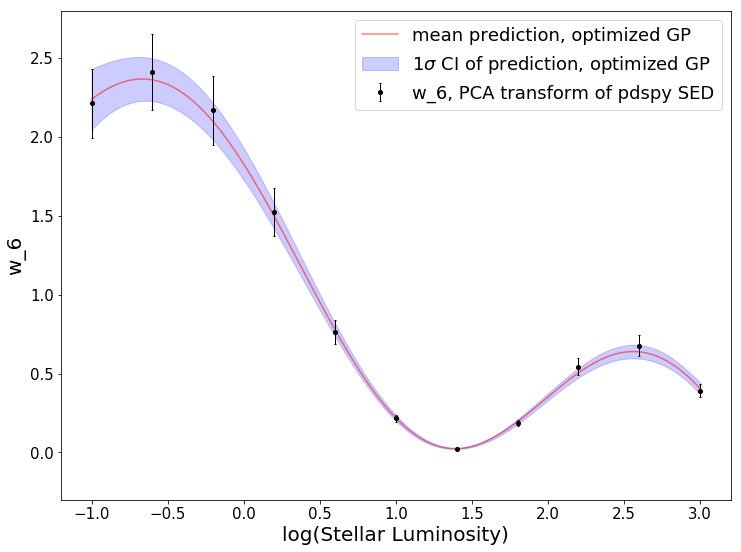

Initial ln-likelihood: -0.41


In [476]:
plt.figure(figsize=(12,9))
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="b", alpha=0.2, label="1"+"$\sigma$"+" CI of prediction, optimized GP")
plt.plot(x_pred, pred, "r", lw=1.5, alpha=0.5, label="mean prediction, optimized GP")
plt.errorbar(X, y, yerr,fmt=".k", capsize=1,markersize=8,lw=1,label="w_6, PCA transform of pdspy SED")
plt.xlabel("log(Stellar Luminosity)",fontsize=20)
plt.ylabel("w_6",fontsize=20)
plt.ylim(-0.3,2.8)
plt.tick_params(labelsize=15)
plt.legend(prop={'size':18})
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

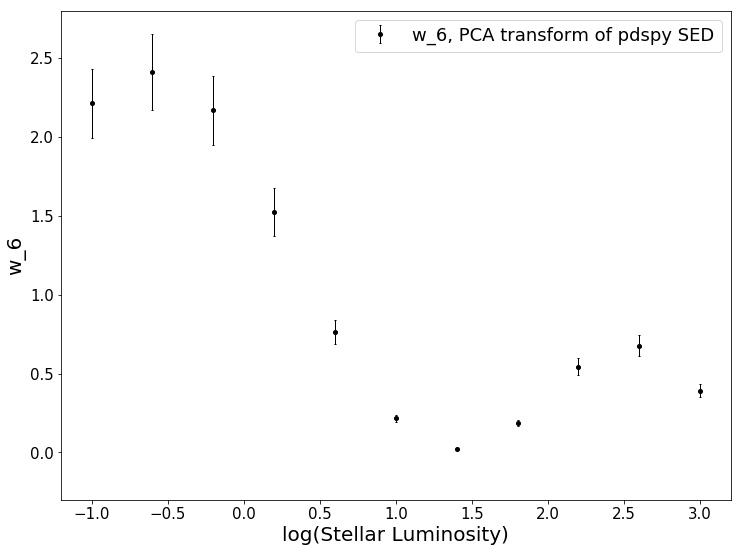

Initial ln-likelihood: -0.41


In [416]:
plt.figure(figsize=(12,9))
plt.errorbar(X, y, yerr,fmt=".k", capsize=1,markersize=8,lw=1,label="w_6, PCA transform of pdspy SED")
plt.xlabel("log(Stellar Luminosity)",fontsize=20)
plt.ylabel("w_6",fontsize=20)
plt.ylim(-0.3,2.8)
plt.tick_params(labelsize=15)
plt.legend(prop={'size':18})
plt.show()

print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

In [286]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

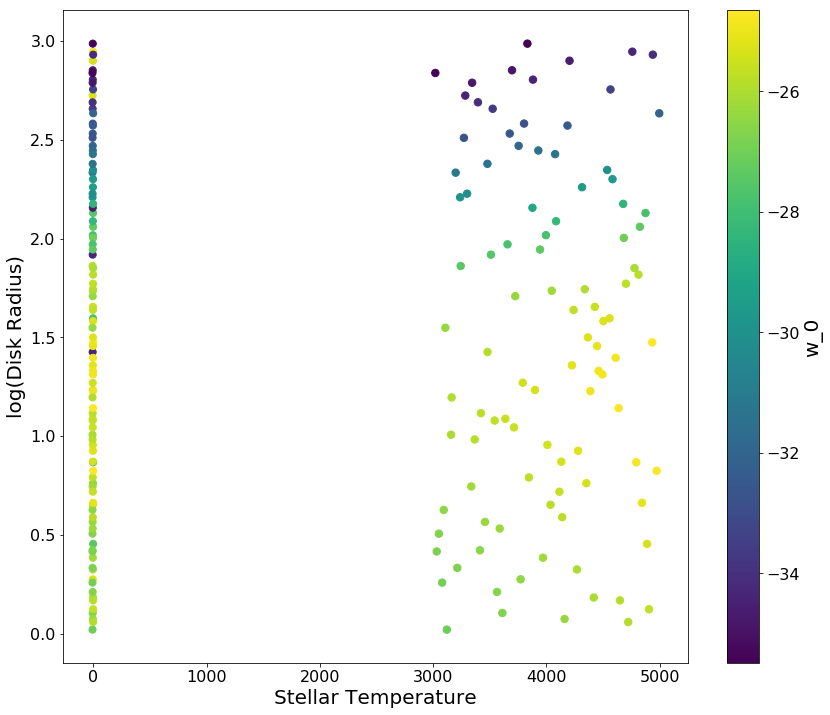

In [287]:
#directory="../grid/2dgrid/"
#coords=[[],[]]
#seds=[]
#for i in range(len(os.listdir(directory))):
#    coords[0].append(float(os.listdir(directory)[i].split("_")[(2*0)+1]))
#    coords[1].append(float(os.listdir(directory)[i].split("_")[(2*3)+1]))
#    filename=os.listdir(directory)[i]
#    model=modeling.YSOModel()
#    model.read_yso(directory+filename)
#    seds.append(np.log10(model.spectra["SED"].flux))
    
#with open('../grid_metadata/2dgrid_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)
with open ('../grid_metadata/2dgrid_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)
#with open('../grid_metadata/2dgrid_seds.txt', 'wb') as fp:
#    pickle.dump(seds, fp)
with open ('../grid_metadata/2dgrid_seds.txt', 'rb') as fp:
    slicevals = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/2dgrid_seds.txt', 'rb') as fp:
    nanslicevals = np.array(pickle.load(fp))[:,100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    if -np.inf in slicevals[i]:
        a = slicevals[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = slicevals[i][ind]
        for j in range(ind):
            slicevals[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=1)[:,np.newaxis]


fitdata=[]
for i in range(len(slicevals)):
    data=[coords[0][i],coords[1][i]]
    coeffs=pca.transform(slice_seds_msub[i].reshape(1,-1))
    for j in range(15):
        data.append(coeffs[0][j])
    fitdata.append(data)
fitdata=np.array(fitdata)

plt.figure(figsize=(14,12))
Tstar=fitdata[:,0]
logR_disk=fitdata[:,1]
w0=fitdata[:,2+0]
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(Tstar,logR_disk, c=w0, s=55, **style)
cb=plt.colorbar()
cb.set_label(label='w_0',size=20)
cb.ax.tick_params(labelsize=16)
plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style)#,edgecolors='r')
plt.xlabel("Stellar Temperature",size=20)
plt.ylabel("log(Disk Radius)",size=20)
plt.tick_params(labelsize=16)

plt.show()

In [419]:
sample=[]
for i in (0,1,2,3,4,5,6,7,8,9,9.9):
    sample.append(np.array([0,10,20,30,40,50,60,70,80,90,99])+[1000*i])
sample=np.array(sample).flatten()
sample=np.ndarray.tolist(sample)
sample=list(map(int,sample))

Initial ln-likelihood: -239.18
[ 1.62459341 18.42068074 -0.4462871 ]
[    2.2530767 10000.            0.8      ]


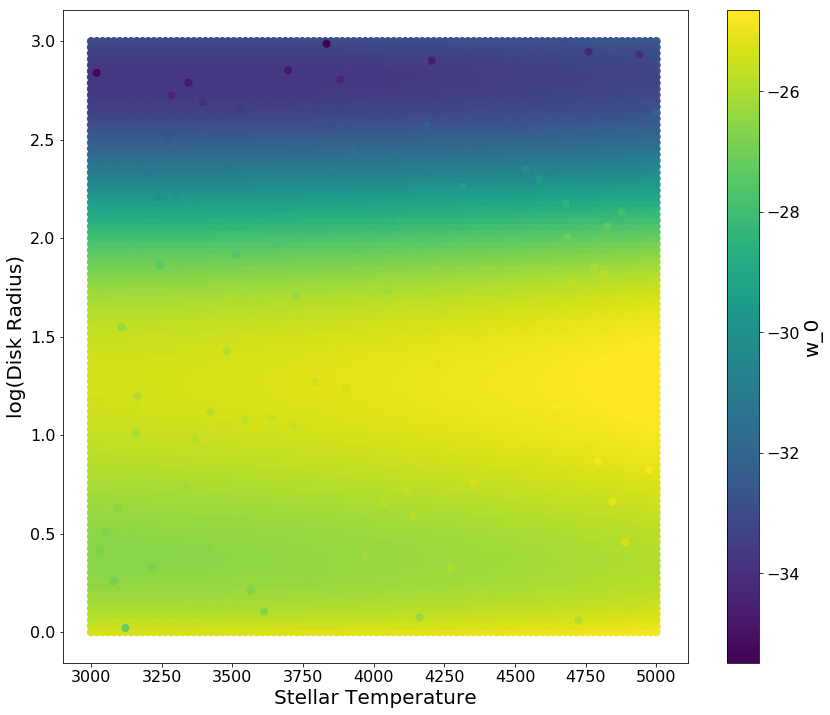

In [470]:
x=np.transpose(coords)
yerr=0.05*w0
kernel = np.var(w0) * kernels.ExpSquaredKernel(10000**2,ndim=2,axes=0)* kernels.ExpSquaredKernel(0.8**2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

np.set_printoptions(suppress=True)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(3000, 5000, 100),np.linspace(0, 3, 100))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(14,12))
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=55, **style)
cb=plt.colorbar()
cb.set_label(label='w_0',size=20)
cb.ax.tick_params(labelsize=16)
plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style)#,edgecolors='r')
plt.xlabel("Stellar Temperature",size=20)
plt.ylabel("log(Disk Radius)",size=20)
plt.tick_params(labelsize=16)

plt.show()

      fun: 143.08422676173225
 hess_inv: array([[0.81298108, 0.73541523, 0.35641369],
       [0.73541523, 1.66300168, 0.25163631],
       [0.35641369, 0.25163631, 0.39866792]])
      jac: array([-0.0000004 ,  0.00000021,  0.00000022])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 16
     njev: 18
   status: 0
  success: True
        x: array([ 5.87867413, 21.01136513,  1.58890625])

Final ln-likelihood: -143.08
[   18.90331053 36522.45533869     2.21323031]


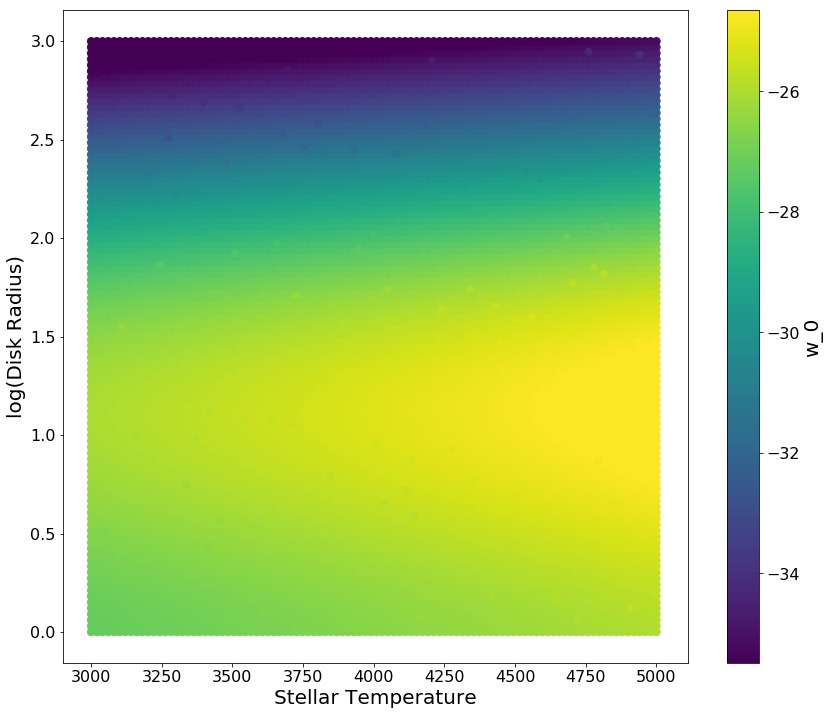

In [471]:
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(w0)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(w0)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(w0)))

print(np.sqrt(np.exp(gp.get_parameter_vector())))

pred, pred_var = gp.predict(w0, x_pred, return_var=True)

plt.figure(figsize=(14,12))
style = dict(cmap='viridis', vmin=np.min(w0), vmax=np.max(w0))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=55, **style)
cb=plt.colorbar()
cb.set_label(label='w_0',size=20)
cb.ax.tick_params(labelsize=16)
plt.scatter(x[:, 0], x[:, 1], c=w0, s=50, **style)#,edgecolors='r')
plt.xlabel("Stellar Temperature",size=20)
plt.ylabel("log(Disk Radius)",size=20)
plt.tick_params(labelsize=16)

plt.show()

In [290]:
#directory="../grid/grid23/"
#coords=[[],[]]
#seds=[]
#for i in range(len(os.listdir(directory))):
#    coords[0].append(float(os.listdir(directory)[i].split("_")[(2*2)+1]))
#    coords[1].append(float(os.listdir(directory)[i].split("_")[(2*3)+1]))
#    filename=os.listdir(directory)[i]
#    model=modeling.YSOModel()
#    model.read_yso(directory+filename)
#    seds.append(np.log10(model.spectra["SED"].flux))
    
#with open('../grid_metadata/grid23_coords.txt', 'wb') as fp:
#    pickle.dump(coords, fp)
with open ('../grid_metadata/grid23_coords.txt', 'rb') as fp:
    coords = pickle.load(fp)
#with open('../grid_metadata/grid23_seds.txt', 'wb') as fp:
#    pickle.dump(seds, fp)
with open ('../grid_metadata/grid23_seds.txt', 'rb') as fp:
    slicevals = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/grid23_seds.txt', 'rb') as fp:
    nanslicevals = np.array(pickle.load(fp))[:,100:500]
    
# fix -infs: powerlaw cutoff
for i in range(len(slicevals)):
    if -np.inf in slicevals[i]:
        a = slicevals[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = slicevals[i][ind]
        for j in range(ind):
            slicevals[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
                
nanslicevals[nanslicevals<-20]=np.nan

# subtracting from the seds each sample mean
slice_seds_msub = slicevals - np.nanmean(nanslicevals,axis=1)[:,np.newaxis]

fitdata=[]
for i in range(len(slicevals)):
    data=[coords[0][i],coords[1][i]]
    coeffs=pca.transform(slice_seds_msub[i].reshape(1,-1))
    for j in range(15):
        data.append(coeffs[0][j])
    fitdata.append(data)
fitdata=np.array(fitdata)

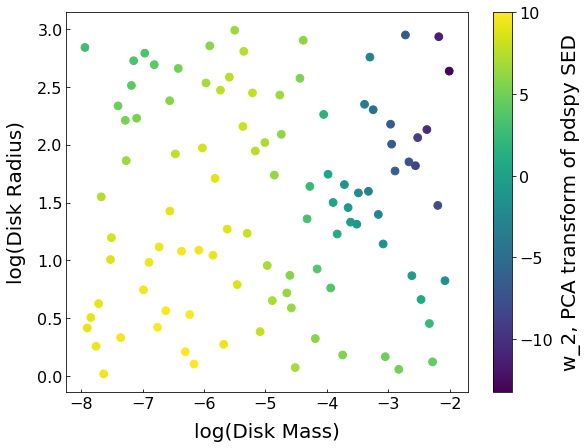

In [298]:
plt.figure(figsize=(9,7))
logM_disk=fitdata[:,0]
logR_disk=fitdata[:,1]
w2=fitdata[:,2+2]
style = dict(cmap='viridis', vmin=np.min(w2), vmax=np.max(w2))
plt.scatter(logM_disk,logR_disk, c=w2, s=60, **style)
cb=plt.colorbar()
cb.set_label(label='w_2, PCA transform of pdspy SED',size=20,labelpad=8)
cb.ax.tick_params(labelsize=16)
plt.xlabel("log(Disk Mass)",size=20,labelpad=11)
plt.ylabel("log(Disk Radius)",size=20,labelpad=11)
plt.tick_params(labelsize=16,direction="in")
plt.show()

Initial ln-likelihood: -117.54
[ 2.80426456  0.         -0.4462871 ]
[4.06385601 1.         0.8       ]


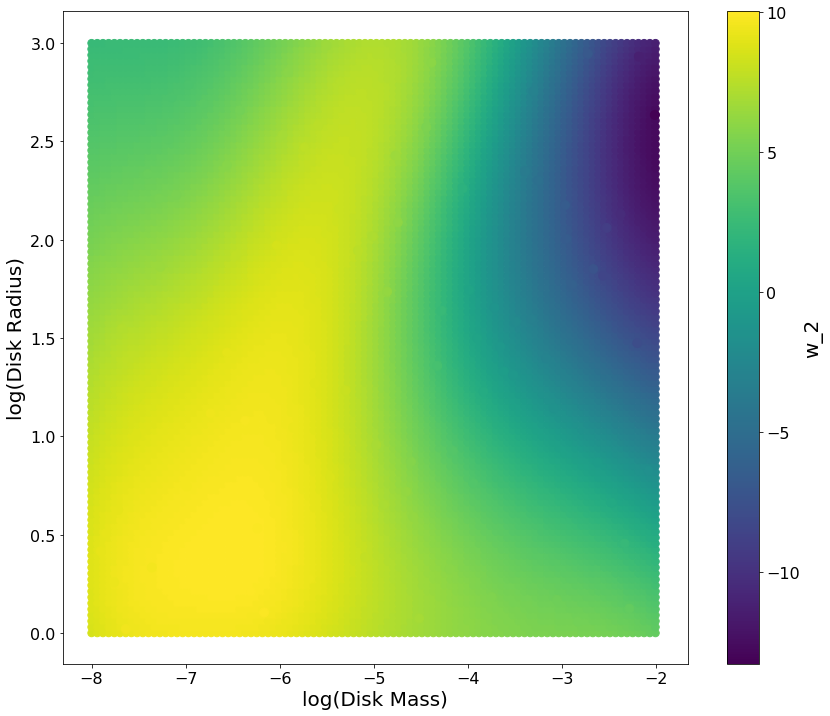

In [300]:

x=np.transpose(coords)
yerr=0.1*w2
kernel = np.var(w2) * kernels.ExpSquaredKernel(1**2,ndim=2,axes=0)* kernels.ExpSquaredKernel(0.8**2,ndim=2,axes=1)
gp = george.GP(kernel)
gp.compute(x,yerr)

np.set_printoptions(suppress=True)
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(w2)))
print(gp.get_parameter_vector())
print(np.sqrt(np.exp(gp.get_parameter_vector())))

x0pred,x1pred=np.meshgrid(np.linspace(-8, -2, 100),np.linspace(0, 3, 100))
x_pred=list(map(lambda x, y:(x,y), np.ndarray.flatten(x0pred), np.ndarray.flatten(x1pred)))
pred, pred_var = gp.predict(w2, x_pred, return_var=True)

plt.figure(figsize=(14,12))
style = dict(cmap='viridis', vmin=np.min(w2), vmax=np.max(w2))
plt.scatter(np.array(x_pred)[:,0], np.array(x_pred)[:,1], c=pred, s=55, **style)
cb=plt.colorbar()
cb.set_label(label='w_2',size=20)
cb.ax.tick_params(labelsize=16)
plt.scatter(x[:, 0], x[:, 1], c=w2, s=80, **style)#,edgecolors='r')
plt.xlabel("log(Disk Mass)",size=20)
plt.ylabel("log(Disk Radius)",size=20)
plt.tick_params(labelsize=16)

plt.show()

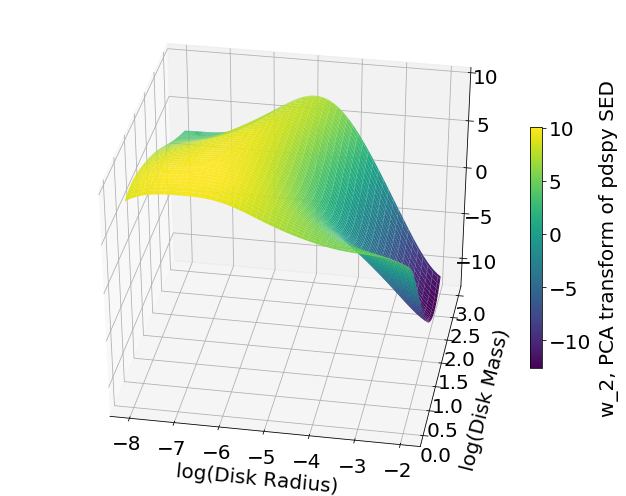

In [322]:
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111,projection='3d')

# Plot the surface.
surf = ax.plot_surface(x0pred,x1pred,pred.reshape(100,100),cmap=cm.viridis)
ax.set_ylabel("log(Disk Mass)",size=20,labelpad=20)
ax.set_xlabel("log(Disk Radius)",size=20,labelpad=12)
ax.tick_params(labelsize=20)
cb=fig.colorbar(surf,shrink=0.5,pad=-0.05)
cb.set_label(label='w_2, PCA transform of pdspy SED',size=20,labelpad=8)

cb.ax.tick_params(labelsize=20)
ax.view_init(35,280)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

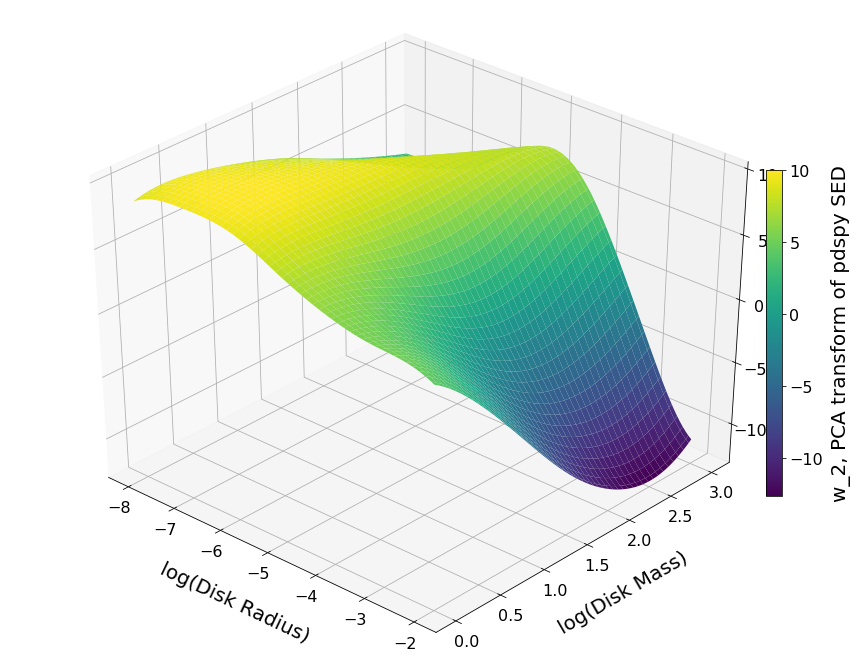

In [301]:
fps = 10 # frame per sec
frn = 200 # frame number of the animation

angles=np.ndarray.tolist(280*np.ones(10))
for i in range(180):
    angles.append(np.ndarray.tolist(np.linspace(280,280+180,180))[i])
for i in range(10):
    angles.append(280)

def update_plot(i, angles, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(x0pred,x1pred,pred.reshape(100,100),cmap=cm.viridis)
    ax.view_init(35,angles[i])

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='3d')

ax.set_ylabel("log(Disk Mass)",size=20,labelpad=20)
ax.set_xlabel("log(Disk Radius)",size=20,labelpad=20)
ax.tick_params(labelsize=16)
cb=fig.colorbar(surf,shrink=0.5,pad=-0.05)
cb.ax.tick_params(labelsize=16)
cb.set_label(label='w_2, PCA transform of pdspy SED',size=20,labelpad=8)

ax.view_init(35,45)

plot = [ax.plot_surface(x0pred,x1pred,pred.reshape(100,100),cmap=cm.viridis)]
ani = FuncAnimation(fig, update_plot, frn, fargs=(angles, plot), interval=1000/fps)
ani.save("../talk/rotateslow.gif", dpi=72, writer="imagemagick")

In [35]:
param_names = ["Tstar","logL_star","logM_disk","logR_disk","h_0","logR_in",\
          "gamma","beta","logM_env","logR_env","f_cav","ksi","loga_max","p","incl"]

bases=[4000.0, 1.0, -5.0, 1.5, 0.255, 0.75, 1.0, 1.25, -5.0, 3.25, 0.5, 1.0, 2.5, 3.5, 45.0]
ranges = [[3000.,5000.], [-1,3.],[-8.,-2.], [0.,3.],[0.01,0.5],[-1.,2.5],[0.0,2.0],\
        [0.5,2.0],[-8.,-2.],[2.5,4.], [0.,1.], [0.5,1.5],[0.,5.],[2.5,4.5],[0.,90.]]

dictionary=np.load("../grid_metadata/dictionary.npy")

# get all model data
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    cube = np.array(pickle.load(fp))[:,100:500]
with open ('../grid_metadata/cubefull.txt', 'rb') as fp:
    nancube = np.array(pickle.load(fp))[:,100:500]
    
# x values (wavelengths) - 500 values, in normal space
with open ('../grid_metadata/xvals.txt', 'rb') as fp:
    xvals = pickle.load(fp)[100:500]

# fix -infs: powerlaw cutoff
for i in range(len(cube)):
    if -np.inf in cube[i]:
        a = cube[i].tolist()
        a.reverse()
        ind = len(a)-a.index(-np.inf)
        x1 = xvals[ind]
        y1 = cube[i][ind]
        for j in range(ind):
            cube[i][j]=(100*(np.log10(xvals[j]/x1)))+y1
            
# nan cutoff for means            
nancube[nancube<-20]=np.nan

# subtracting from the seds each sample mean
seds_msub = cube - np.nanmean(nancube,axis=1)[:,np.newaxis]

t0 = time()
pca = PCA(n_components=40).fit(seds_msub)
print("done in %0.3fs" % (time() - t0))

eigenseds=np.array(pca.components_)

fitdata=[]

for i in range(len(cube)):
    modeldata=[]
    coeffs=pca.transform(seds_msub[i].reshape(1,-1))
    for k in range(15):
        modeldata.append(coeffs[0][k])
    fitdata.append(modeldata)
    
def load_pcwpar(weight):
    p=[]
    w=[]
    m=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        w.append(fitdata[i][weight])
        m.append(np.nanmean(nancube,axis=1)[i])
    
    return p,w,m

def load_pcwpar_all():
    p=[]
    w=[]
    m=[]
    for i in range(len(cube)):
        pars=[]
        for j in range(len(param_names)):
            pars.append(dictionary[i][param_names[j]])
        p.append(pars)
        weights=[]
        for k in range(15):
            weights.append(fitdata[i][k])
        w.append(weights)
        m.append(np.nanmean(nancube,axis=1)[i])
    return p,w,m

Xs,ws,ms=load_pcwpar_all()
ws=np.transpose(ws)
ws1=np.ndarray.tolist(ws)
ws1.append(ms)
ws=ws1

yerrs=[]
for i in range(16):
    yerrs.append([x*0.01 for x in ws[i]])

done in 0.026s


In [36]:
t0=time()
gps=[]
for i in range(len(ws)):
    kernel = np.var(ws[i])*kernels.ExpSquaredKernel(10000**2,ndim=15,axes=0)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=1)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=2)*\
        kernels.ExpSquaredKernel(0.8**2,ndim=15,axes=3)*\
        kernels.ExpSquaredKernel(0.08**2,ndim=15,axes=4)*\
        kernels.ExpSquaredKernel(0.5**2,ndim=15,axes=5)*\
        kernels.PolynomialKernel(1.7,15,ndim=15,axes=6)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=7)*\
        kernels.ExpSquaredKernel(1**2,ndim=15,axes=8)*\
        kernels.ExpSquaredKernel(0.2**2,ndim=15,axes=9)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=10)*\
        kernels.ExpSquaredKernel(0.25**2,ndim=15,axes=11)*\
        kernels.ExpSquaredKernel(2**2,ndim=15,axes=12)*\
        kernels.ExpSquaredKernel(3**2,ndim=15,axes=13)*\
        kernels.ExpSquaredKernel(5**2,ndim=15,axes=14) 

    #11, ksi - not smooth. may need to change kernel
    #6 is gamma - polynomial kernel for tail
    # change lengthscale for 7 to ~4 or 5

    gps.append(george.GP(kernel))
    gps[i].compute(Xs,yerrs[i])
print("done in %0.3fs" % (time() - t0))

done in 66.262s


In [29]:
gps[0].get_parameter_vector()

array([ 6.33043192, 18.42068074,  0.        ,  0.        , -0.4462871 ,
       -5.05145729, -1.38629436,  1.7       , -3.21887582,  0.        ,
       -3.21887582, -2.77258872, -2.77258872,  1.38629436,  2.19722458,
        3.21887582])

In [37]:
np.sqrt(np.exp(gps[0].get_parameter_vector()))

array([   23.69385994, 10000.        ,     1.        ,     1.        ,
           0.8       ,     0.08      ,     0.5       ,     2.33964685,
           0.2       ,     1.        ,     0.2       ,     0.25      ,
           0.25      ,     2.        ,     3.        ,     5.        ])

In [38]:
#xpred=[]
#for i in range(15):
#    xpred.append(dictionary[400][param_names[i]])
#for i in range(15):
#    r=(ranges[i][1]-ranges[i][0])*.1
#    xpred[i]+=np.random.uniform(-r,r)
xpred=[4224.652498842656,
 1.6884032411670775,
 -5.800598713940963,
 2.476406814353194,
 0.4488586243690123,
 2.0509265487337545,
 1.7591769570151077,
 0.6507337432872502,
 -2.004297466901181,
 3.2432836328740122,
 0.8129056548367177,
 1.3924939842898323,
 0.9225713243976206,
 3.0417875028026673,
 3.2731233193688354]


In [41]:
a=[]
for i in range(2):
    a.append(xpred)

In [45]:
t0=time()
preds=[]
for i in range(16):
    pred, pred_var = gps[i].predict(ws[i], a, return_var=True)
    preds.append(pred)
print("done in %0.3fs" % (time() - t0))

done in 0.685s


In [46]:
for i in range(16):
    print("w"+str(i)+" = "+str(np.round(np.array(preds)[:,0][i],4)))

w0 = 32.789
w1 = -3.5814
w2 = -8.3414
w3 = 0.7738
w4 = 0.9258
w5 = 1.7709
w6 = -0.338
w7 = 0.4995
w8 = 0.1231
w9 = 0.2094
w10 = -0.2286
w11 = -0.0065
w12 = 0.0054
w13 = -0.0083
w14 = 0.0839
w15 = -0.2989


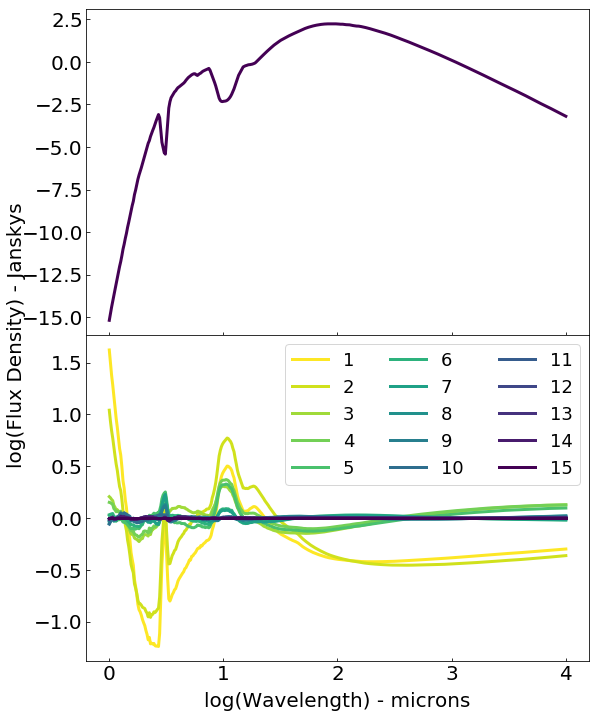

In [326]:
colors=plt.cm.viridis(np.flip(np.linspace(0,1,15)))
fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,figsize=(9,12))
coeffs=np.array(preds)[:,0]
reconst_15=np.dot(coeffs[0:14+1],eigenseds[0:14+1,0:400]) +pca.mean_[0:400]+coeffs[15]
for i in range(0,15):
    ax[1].plot(np.log10(xvals),np.dot(coeffs[0:i+1],eigenseds[0:i+1,0:400]) + pca.mean_[0:400]+\
             coeffs[15]-reconst_15,label=str(i+1),c=colors[i],lw=3)
ax[0].plot(np.log10(xvals),reconst_15,c=colors[14],lw=3)
ax[1].tick_params(labelsize=20,direction="in")
ax[0].tick_params(labelsize=20,direction="in")
plt.ylabel("log(Flux Density) - Janskys",fontsize=20,labelpad=8)
plt.xlabel("log(Wavelength) - microns",fontsize=20,labelpad=8)
ax[1].yaxis.set_label_coords(-0.12,1)
fig.subplots_adjust(hspace=0)
ax[1].legend(prop={'size':18},ncol=3)
plt.show()

Text(0.5, 0, 'log(Wavelength) - microns')

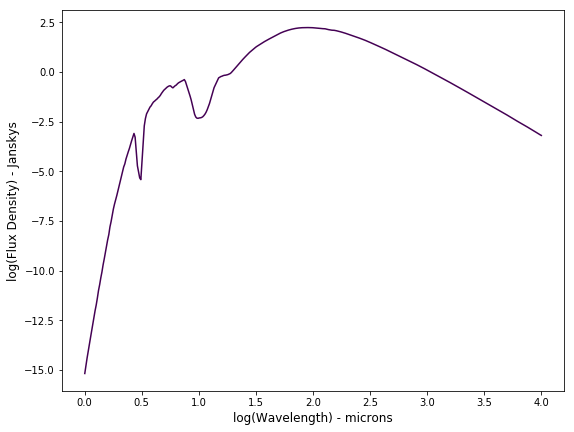

In [234]:
colors=plt.cm.viridis(np.flip(np.linspace(0,1,15)))
plt.figure(figsize=(9,7))
coeffs=np.array(preds)[:,0]
reconst_15=np.dot(coeffs[0:14+1],eigenseds[0:14+1,0:400]) +pca.mean_[0:400]+coeffs[15]
plt.plot(np.log10(xvals),reconst_15,c=colors[14])
plt.tick_params(labelsize=10)
plt.ylabel("log(Flux Density) - Janskys",fontsize=12)
plt.xlabel("log(Wavelength) - microns",fontsize=12)


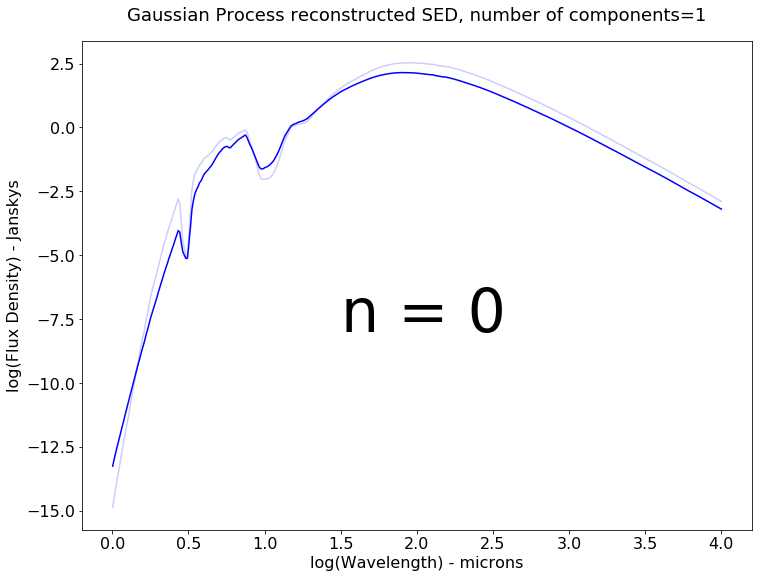

In [571]:
ncomp=15
nfeat=400
fig,ax= plt.subplots(figsize=(12,9))
coeffs=np.array(preds)[:,0]
reconst=[]
for j in range(ncomp):
    reconst.append(np.dot(coeffs[0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                   pca.mean_[0:nfeat])
ax.plot(np.log10(xvals),reconst[14],c='b',alpha=0.2)
ax.tick_params(labelsize=16)
line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

ann_list=[]
def animate(i):
    if not len(ann_list)==0:
        ax.texts.remove(ax.texts[0])
    line.set_ydata(reconst[int(i)])
    ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
    ann=ax.annotate("n = "+str(i),(1.5,-8),size=60)
    ann_list.append(ann)
    ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
    ax.set_title("Gaussian Process reconstructed SED, number of components="+str(int(i)+1),fontsize=18,pad=20)
    return line,ax

#fs=np.ndarray.tolist(np.arange(0,ncomp))
#for i in range(4):
#    fs.append(ncomp-1)
fs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14]
anim=FuncAnimation(fig,animate,frames=fs,interval=800)
anim.save("../talk/test_gp_reconst_2.gif", dpi=72, writer="imagemagick")

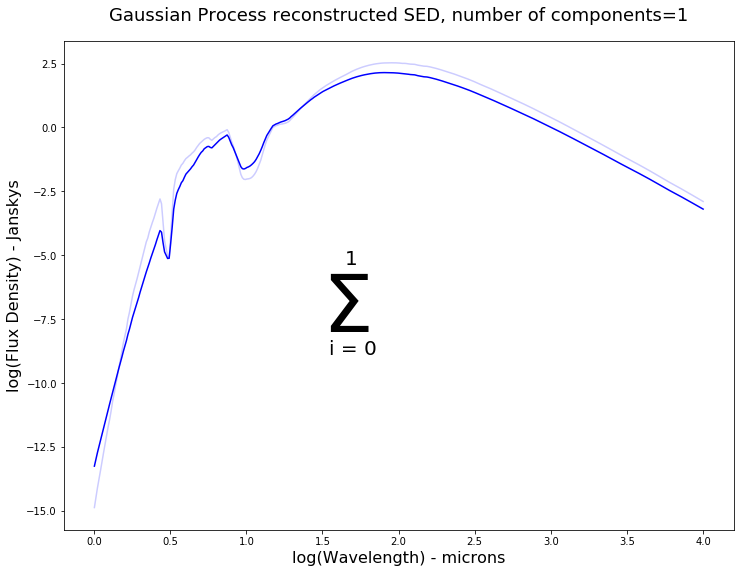

In [572]:
ncomp=15
nfeat=400
fig,ax= plt.subplots(figsize=(12,9))
coeffs=np.array(preds)[:,0]
reconst=[]
for j in range(ncomp):
    reconst.append(np.dot(coeffs[0:j+1],eigenseds[0:j+1,0:nfeat]) +\
                   pca.mean_[0:nfeat])
ax.plot(np.log10(xvals),reconst[14],c='b',alpha=0.2)
ax.annotate("$\Sigma$",(1.5,-8),size=80)
ax.annotate("i = 0",(1.54,-8.9),size=20)
line, = ax.plot(np.log10(xvals)[0:nfeat], reconst[0], c='b')

ann_list=[]
def animate(i):
    if not len(ann_list)==0:
        ax.texts.remove(ax.texts[2])
    line.set_ydata(reconst[int(i)])
    ax.set_xlabel("log(Wavelength) - microns",fontsize=16)
    ann=ax.annotate(str(i+1),(1.65,-5.35),size=20)
    ann_list.append(ann)
    ax.set_ylabel("log(Flux Density) - Janskys",fontsize=16)
    ax.set_title("Gaussian Process reconstructed SED, number of components="+str(int(i)+1),fontsize=18,pad=20)
    return line,ax

#fs=np.ndarray.tolist(np.arange(0,ncomp))
#for i in range(4):
#    fs.append(ncomp-1)
fs=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14]
anim=FuncAnimation(fig,animate,frames=fs,interval=800)
anim.save("../talk/test_gp_reconst_3.gif", dpi=72, writer="imagemagick")